In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
import seaborn as sns
import random as rn
import re
import warnings
import csv
import math

import tensorflow as tf
# Force TensorFlow to single thread
# Multiple threads are a potential source of non-reprocible research resulsts
session_conf = tf.compat.v1.ConfigProto( intra_op_parallelism_threads=1, inter_op_parallelism_threads=1 )

# tf.set_random_seed() will make random number generation in the TensorFlow backend
# have a well defined initial state
# more details: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.compat.v1.set_random_seed(515)

# keras / deep learning libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

# callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import pylab as pl
from pylab import savefig
plt.style.use('seaborn-deep')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import pylab as pl
from pylab import savefig
plt.style.use('seaborn-deep')

from sklearn import datasets

%matplotlib inline
from matplotlib.pyplot import figure

from mlxtend.plotting import plot_decision_regions

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
def plot_decision_boundary(X_train, y_train, X, model, enc, s, size=(5,5), steps=1000, cmap='Paired'):
    cmap = plt.get_cmap(cmap)

    # Define region of interest by data limits
    xmin, xmax = X_train[:,0].min() - 1, X_train[:,0].max() + 1
    ymin, ymax = X_train[:,1].min() - 1, X_train[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels = enc.inverse_transform(model.predict(np.c_[xx.ravel(), yy.ravel()]))

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)

    fig = figure(num=None, figsize=size, dpi=150)
    plt.contourf(xx, yy, z, cmap=cmap, alpha=0.5, vmin = 0, vmax = 1 )

    # Get predicted labels on training data and plot
    train_labels = model.predict(X)
    plt.scatter(X_train[:,0], X_train[:,1], s = s, c=y_train, cmap=cmap, lw=0)
    plt.scatter(X[:,0], X[:,1], s = s, c="g", lw=0)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    return fig

In [37]:

def create_model(input_dim, output_dim, nodes, hidden_layers=1, loss_func='categorical_crossentropy', optim='nadam', metrics=['accuracy'], name='model'):
    
    model = Sequential(name=name)
    model.add( Dense(nodes[0], input_dim=input_dim, activation='relu'))  # input layer
    for i in range(hidden_layers):                                    # hidden layers
        model.add(Dense(nodes[i+1], activation='relu'))  
    model.add(Dense(output_dim, activation='softmax'))                # output layer

    if( optim == "nadam" ):                                           # Compile model
        optim = keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999)

    model.compile(loss=loss_func, optimizer=optim, 
                  metrics=metrics)
    return model

((3000,), (3000, 2))

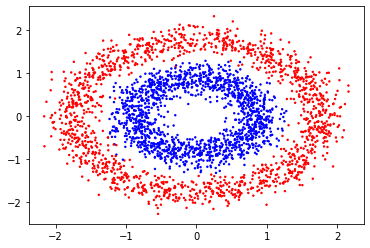

In [38]:
X, y = datasets.make_circles(n_samples = 3000, noise = 0.1, factor=0.5, random_state=0)
X = StandardScaler().fit_transform(X)
colors = ['blue' if label == 1 else 'red' for label in y]
plt.scatter(X[:,0], X[:,1], color=colors, s = 2)
y.shape, X.shape


In [39]:
# create numerical encoding for attribute species
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# generate train, test and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=515)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=515)
	

In [43]:
# define model
model = create_model(2, 2, [12, 10, 8, 4], hidden_layers=3 )
model

In [44]:

history_callback = model.fit(X_train, Y_train, batch_size = 50, epochs = 500, verbose=0, validation_data=(X_validation, Y_validation))
score_test = model.evaluate( X_test, Y_test, verbose=0 )
score_train = model.evaluate( X_train, Y_train  )
		
print('Test loss:     ', format(score_test[0], '.4f'), '\tTrain loss: ', format(score_train[0], '.4f') )
print('Test accuracy: ', format(score_test[1], '.4f'), '\tTrain accu: ', format(score_train[1], '.4f') )
print('Abs accuracy:  ', format( np.abs( score_test[1] - score_train[1] ), '.4f'))
print('Abs loss:      ', format( np.abs( score_test[0] - score_train[0] ), '.4f'))
print('\n###########################################################\n')



66/66 [==============================] - 0s 3ms/step - loss: 0.0146 - accuracy: 0.9971
Test loss:      0.0211 	Train loss:  0.0146
Test accuracy:  0.9933 	Train accu:  0.9971
Abs accuracy:   0.0038
Abs loss:       0.0065

###########################################################



In [8]:
def permute_single_featuresBase( my_array, distr, samples = 300, variance = 0.1 ):

    permutations = []               # permutation result list
    my_array = np.round(my_array,4) # just keeping a controlled number of decimal places

    # keep a copy of the original array, since we will be changing the features
    my_array_backup = my_array

    num_features = my_array.shape[0]                # extract number of features
    permutations.append( my_array_backup.tolist() ) # add original vector to dataframe

    # get feature value
    my_array = my_array_backup
    x1_val = my_array[0]
    x2_val = my_array[1]        
    
    # generate sample of random features within a range
    for perm in range( 0, samples ):
      theta = 2*math.pi*np.random.random()
      r = variance #*math.sqrt(random.random())
      
      my_array[0] = np.round(x1_val + r * math.cos(theta),4)
      my_array[1] = np.round(x2_val + r * math.sin(theta),4)

      permutations.append( my_array.tolist() )
        
    #rn.shuffle(permutations)
    return permutations

In [9]:
import math

def compute_perm_range(feat, variance = 0.25):

    min_range = feat - variance
    max_range = feat + variance
    
    # features are scaled between 0 and 1
    # if the permutation make the feature negative, this values is set to 0
    if( min_range < 0 ):
        min_range = 0
    # if the permutation make the feature bigger than 1, this values is set to 1   
    if( max_range > 1 ):
        max_range = 1
        
    return min_range, max_range 





In [47]:
test = X_test[0:][0]-0.1

permsVeryLow = np.array(permute_single_featuresBase( test , distr="normal",samples = 300, variance = 0.05))
permsLow = np.array(permute_single_featuresBase( test , distr="normal",samples = 300, variance = 0.1))
permsBig = np.array(permute_single_featuresBase( test , distr="normal",samples = 300, variance = 0.25)) 

l = []
for i in range(0,len(permsLow)):
  l.append( Y_test[0] )


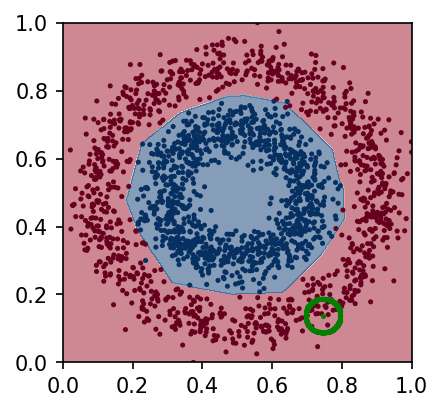

In [48]:
f = plot_decision_boundary(X_train, enc.inverse_transform(Y_train), permsVeryLow, model, enc, s = 6, size=(3,3), cmap='RdBu')

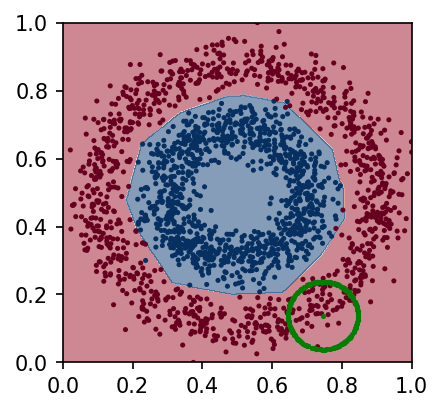

In [49]:
f = plot_decision_boundary(X_train, enc.inverse_transform(Y_train), permsLow, model, enc, s = 6, size=(3,3), cmap='RdBu')

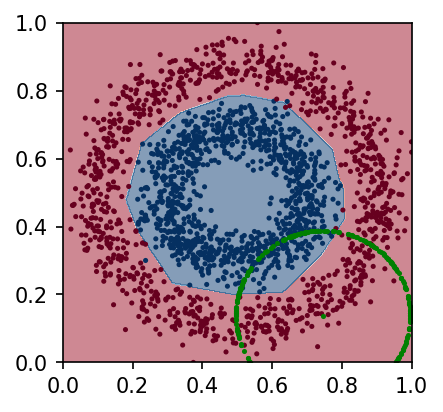

In [50]:
f = plot_decision_boundary(X_train, enc.inverse_transform(Y_train), permsBig, model, enc, s = 6, size=(3,3), cmap='RdBu')

In [51]:
test = X_test[0:][0]-0.1

permsVeryLow = np.array(permute_single_features( test,samples = 300, variance = 0.05))
permsLow = np.array(permute_single_features( test, samples = 300, variance = 0.1))
permsBig = np.array(permute_single_features( test, samples = 300, variance = 0.25)) 

l = []
for i in range(0,len(permsLow)):
  l.append( Y_test[0] )


In [107]:

def check_input( value ):
  if value < 0:
    return 0
  if value > 1:
    return 1

  return value

def permute_single_features_circle( my_array, samples = 300, variance = 0.25 ):

    # permutation result list
    permutations = []
    # just keeping a controlled number of decimal places
    my_array = np.round(my_array,4)

    # keep a copy of the original array, since we will be changing the features
    my_array_backup = my_array

    # extract number of features
    num_features = my_array.shape[0]

    # add original vector to dataframe
    permutations.append( my_array_backup.tolist() )

    # for each feature of the input feature vector,
    for perm in range(0, int(round(samples/num_features, 0))):
  
      # generate sample of random features within a range
      
      temp1 = []
      temp2 = []
      for feat in range(0, num_features):   
        theta = 2*math.pi*np.random.random()
        feature_val = my_array[feat]

        # set the new vector
        temp1.append( check_input( feature_val + np.round(np.random.uniform(0, variance),4)*math.cos(theta) ))
        temp2.append( check_input(feature_val + np.round(np.random.uniform(0, variance),4)*math.sin(theta) ))

      permutations.append( temp1 )
      permutations.append( temp2 )
        
    #rn.shuffle(permutations)
    return permutations[0:samples]


300


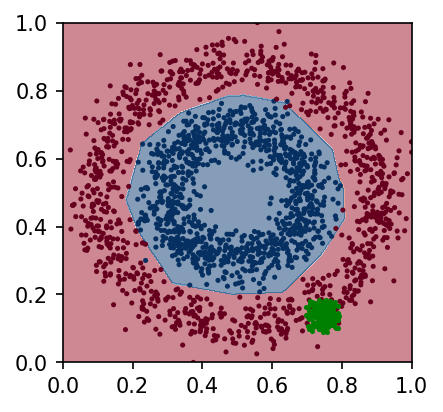

In [108]:
permsVeryLow = np.array(permute_single_features( test,samples = 300, variance = 0.05))
print(len(permsVeryLow))
f = plot_decision_boundary(X_train, enc.inverse_transform(Y_train), permsVeryLow, model, enc, s = 6, size=(3,3), cmap='RdBu')


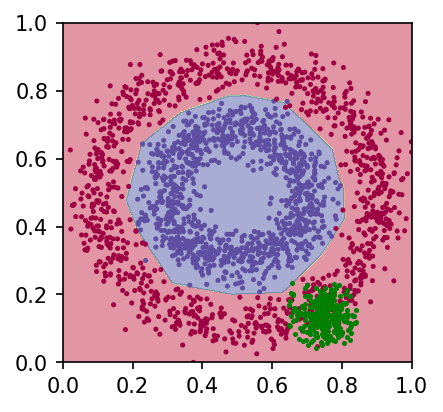

In [110]:
permsLow = np.array(permute_single_features( test,samples = 300, variance = 0.1))
f = plot_decision_boundary(X_train, enc.inverse_transform(Y_train), permsLow, model, enc, s = 6, size=(3,3), cmap='RdBu')

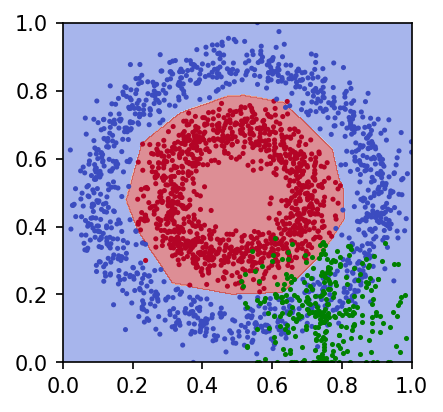

In [111]:
permsBig = np.array(permute_single_features( test,samples = 300, variance = 0.25))
f = plot_decision_boundary(X_train, enc.inverse_transform(Y_train), permsBig, model, enc, s = 6, size=(3,3), cmap='RdBu')

In [ ]:
maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis',
        'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic',
        'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink','spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
        'hot', 'afmhot', 'gist_heat', 'copper', 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 
        'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

for color in maps:
  print(color)
  f = plot_decision_boundary(X_test, enc.inverse_transform(Y_test), model, enc, size=(2,2), cmap=color)



viridis


KeyboardInterrupt: ignored